In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import copy
import pickle
import time

import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange

from mnist_loader import get_dataset
from mnist_model import CNNMnist
from update import LocalUpdate, test_inference

In [44]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_USERS = 100
NUM_USERS_PER_ROUND = 10
EPOCHS = 10
LOCAL_EPOCHS = 10
LOCAL_BATCH_SIZE = 10
iid = False
unequal = True

logger = SummaryWriter('logs')

In [29]:
# load dataset and user groups
train_dataset, test_dataset, user_groups = get_dataset(NUM_USERS, iid, unequal)

<BarContainer object of 100 artists>

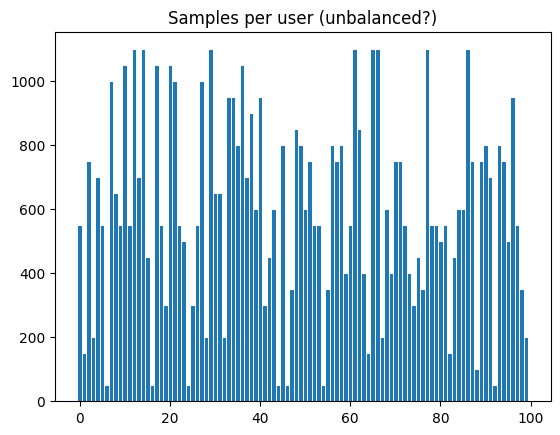

In [30]:
import matplotlib.pyplot as plt
plt.title("Samples per user (unbalanced?)")
plt.bar(user_groups.keys(), [len(_) for _ in user_groups.values()], width=1, edgecolor="white",
        linewidth=0.7)

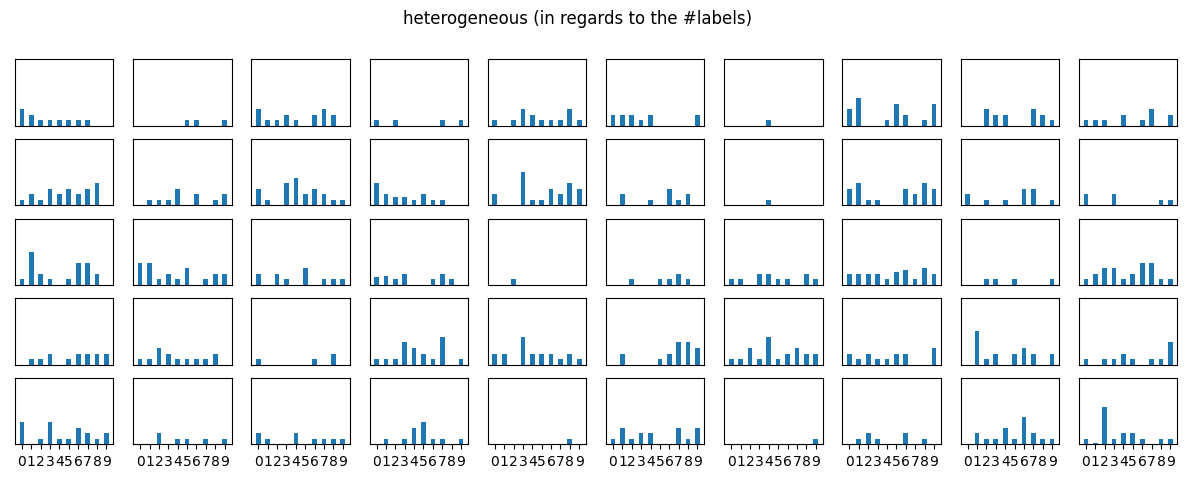

In [31]:
train_data_per_user = {k: torch.utils.data.Subset(train_dataset, v.astype(int)) for k, v in user_groups.items()}

fig, ax = plt.subplots(5, 10, figsize=(15, 5))
fig.suptitle("heterogeneous (in regards to the #labels)")
for r in range(5):
    for c in range(10):
        ax[r][c].set_xlim([-0.75, 9.75])
        ax[r][c].set_ylim([0, 600])
        if r == 4:
            ax[r][c].set_xticks(range(10))
        else:
            ax[r][c].set_xticks([])
        ax[r][c].set_yticks([])
        ax[r][c].hist([label for image, label in train_data_per_user[r * 10 + c]], bins=np.arange(22) / 2 - 0.25)

In [33]:
def server_aggregate(w):
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
    return w_avg


In [49]:
start_time = time.time()
global_model = CNNMnist()

# Set the model to train and send it to device.
global_model.to(DEVICE)
global_model.train()
print(global_model)

# copy weights
global_weights = global_model.state_dict()

# Training
train_loss, valid_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 2
val_loss_pre, counter = 0, 0

for epoch in trange(EPOCHS): # rounds
    local_weights, local_losses = [], []
    print(f'\n | Global Training Round : {epoch + 1} |\n')

    global_model.train()

    idxs_users = np.random.choice(NUM_USERS, NUM_USERS_PER_ROUND, replace=False)

    for idx in idxs_users:
        local_model = LocalUpdate(DEVICE, LOCAL_BATCH_SIZE, LOCAL_EPOCHS, dataset=train_dataset,
                                  idxs=user_groups[idx], logger=logger)
        w, loss = local_model.update_weights(  #  <- implement this
            copy.deepcopy(global_model), epoch, mu=0.005)

        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))

    # aggregate the global weights
    global_weights = server_aggregate(local_weights) #  <- implement this

    # update global weights
    global_model.load_state_dict(global_weights)

    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)

    # Calculate avg training accuracy over all users at every epoch
    list_acc, list_loss = [], []
    global_model.eval()
    for c in range(NUM_USERS):
        local_model = LocalUpdate(DEVICE, LOCAL_BATCH_SIZE, LOCAL_EPOCHS, dataset=train_dataset,
                                  idxs=user_groups[idx], logger=logger)
        acc, loss = local_model.inference(model=global_model)
        list_acc.append(acc)
        list_loss.append(loss)
    valid_accuracy.append(sum(list_acc) / len(list_acc))

    # print global training loss after every 'i' rounds
    if (epoch + 1) % print_every == 0:
        print(f' \nAvg Training Stats after {epoch + 1} global rounds:')
        print(f'Training Loss : {np.mean(np.array(train_loss))}')
        print(f'Validation Accuracy: {100 * valid_accuracy[-1]:.2f}% \n')

# Test inference after completion of training
test_acc, test_loss = test_inference(DEVICE, global_model, test_dataset)

print(f' \n Results after {EPOCHS} global rounds of training:')
print(f'|---- Avg Validation Accuracy: {100 * valid_accuracy[-1]:.2f}%')
print(f'|---- Test Accuracy: {100 * test_acc:.2f}%')

# Saving the objects train_loss and train_accuracy:
file_name = f'save/mnist_cnn_{EPOCHS}_C[{NUM_USERS_PER_ROUND / NUM_USERS}]_iid[{iid}]_E[{LOCAL_EPOCHS}]_B[{LOCAL_BATCH_SIZE}].pkl'

with open(file_name, 'wb') as f:
    pickle.dump([train_loss, valid_accuracy], f)

print(f'\n Total Run Time: {time.time() - start_time:0.4f}')


 | Global Training Round : 2 |

 
Avg Training Stats after 2 global rounds:
Training Loss : 0.6104362264951895
Validation Accuracy: 95.00% 


 | Global Training Round : 3 |


 | Global Training Round : 4 |

 
Avg Training Stats after 4 global rounds:
Training Loss : 0.4511768290638486
Validation Accuracy: 95.00% 


 | Global Training Round : 5 |


 | Global Training Round : 6 |

 
Avg Training Stats after 6 global rounds:
Training Loss : 0.3859907973367269
Validation Accuracy: 95.45% 


 | Global Training Round : 7 |


 | Global Training Round : 8 |

 
Avg Training Stats after 8 global rounds:
Training Loss : 0.337765641765612
Validation Accuracy: 97.27% 


 | Global Training Round : 9 |


 | Global Training Round : 10 |

 
Avg Training Stats after 10 global rounds:
Training Loss : 0.3096485394464733
Validation Accuracy: 95.00% 

 
 Results after 10 global rounds of training:
|---- Avg Validation Accuracy: 95.00%
|---- Test Accuracy: 95.74%

 Total Run Time: 325.3449
CNNMnist(
  (conv

  0%|          | 0/10 [00:00<?, ?it/s]


 | Global Training Round : 1 |


 | Global Training Round : 2 |

 
Avg Training Stats after 2 global rounds:
Training Loss : 0.7337774610552135
Validation Accuracy: 96.36% 


 | Global Training Round : 3 |


 | Global Training Round : 4 |

 
Avg Training Stats after 4 global rounds:
Training Loss : 0.48584150957351746
Validation Accuracy: 97.50% 


 | Global Training Round : 5 |


 | Global Training Round : 6 |

 
Avg Training Stats after 6 global rounds:
Training Loss : 0.4159930132797089
Validation Accuracy: 96.36% 


 | Global Training Round : 7 |


 | Global Training Round : 8 |

 
Avg Training Stats after 8 global rounds:
Training Loss : 0.36612814234294017
Validation Accuracy: 100.00% 


 | Global Training Round : 9 |


 | Global Training Round : 10 |

 
Avg Training Stats after 10 global rounds:
Training Loss : 0.3302968607912349
Validation Accuracy: 100.00% 

 
 Results after 10 global rounds of training:
|---- Avg Validation Accuracy: 100.00%
|---- Test Accuracy: 96.30%

 Tot